In [1]:
# Inflow entrainment
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import gsw

In [2]:
# Find the interface
def Layer(u):
    # Layer interface, zero velocity crossing point
    uzx = u.mean(axis=(0,2)) # Z, X
    X = uzx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0,1]] = 0 # Remove data at fjord head and end
    for i in range(2,X):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [3]:
def Layer_S(S):
    Szx = S.mean(axis=(0,2))
    Sma = np.ma.masked_where(Szx==0, Szx)
    X = Szx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0]] = 0 # Remove data at fjord head
    for i in range(1,X):
        meanS = np.abs(Sma[:,i] - (Sma[:,i].max() + Sma[:,i].min()) / 2)
        itf[i] = np.argmin(meanS)
    return itf

In [4]:
def FluxCoef(state, grid, f, s):
    state1 = state.isel(X=range(120), Y=range(30,39), Xp1=range(121),T=range(275,337))
    grid1 = grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))
    z = grid1.Z.data
    x = grid1.X.data
    dxC = grid1.dxC.data
    xp = grid1.Xp1.data
    u = state1.U.data
    w = state1.W.data
    S = state1.S.data.mean(axis=(0,2))
    Temp = state1.Temp.data.mean(axis=(0,2))
    pres = gsw.p_from_z(z, 56)
    P = np.tile(pres,[len(x),1]).T
    rho = gsw.rho(S, Temp, P) # Density
    g = 9.81
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    #f = 48
    #s = 72
    HFacW = grid1.HFacW.data[:,:,f:s+1] # vertical fraction of open cell at West face
    HFacC = grid1.HFacC.data[:,:,f:s+1].mean(1) # vertical fraction of open cell at cell center
    drF = grid1.drF.data # r cell face separation
    rA = grid1.rA.data[:,f:s+1] # r face area at cell center
    itf = Layer(u)
    it = itf[f:s+1]
    
    ut = u[:,:,:,f:s+1].mean(0)
    uzx = u[:,:,:,f:s+1].mean(axis=(0,2))
    wt = w[:,:,:,f:s+1].mean(0)
    Rho = rho[:,f:s+1]
    dx = dxC[:,f:s+1].mean(0)
    
    Vx1 = np.empty(s-f+1) # Horizontal volume transport for the upper layer
    Vx2 = np.empty(s-f+1) # Horizontal volume transport for the lower layer
    Ux2 = np.empty(s-f+1) # Horizontal velocity for the lower layer
    Vz = np.empty(s-f+1) # Vertical volume transport through the interface
    gr = np.empty(s-f+1) # Reduced gravity
    for i in range(s-f+1):
        
        gh = drF * HFacC[:,i] # grid height
        
        h1 = gh[:it[i]].sum()    
        h2 = gh[it[i]:].sum()

        Vx1[i] = np.sum(ut[:it[i],:,i] * HFacW[:it[i],:,i] * Area[:it[i],:])
        Vx2[i] = np.sum(ut[it[i]:,:,i] * HFacW[it[i]:,:,i] * Area[it[i]:,:])
        Ux2[i] = Vx2[i] / np.sum(HFacW[it[i]:,:,i] * Area[it[i]:,:])
        
        Vz[i] = np.sum(wt[it[i]-1,:,i] * rA[:,i])
        rho1 = np.sum(Rho[:it[i],i] * gh[:it[i]]) / h1
        rho2 = np.sum(Rho[it[i]:,i] * gh[it[i]:]) / h2
        gr[i] = g * (rho2-rho1) / rho2
        
    q2 = np.sum(-Ux2 * dx) 
    Q1 = -Vx2[-1]
    #U1 = -Ux2[-1]
    U1 = -Ux2.mean()
    Q2 = Vx1[-1]
    Q3 = -Vx2[0]
    Q4 = Vx1[0]
    alph34 = (Q3-Q1)/Q4
    alph24 = Q2 / Q4
    Qr = Q4 - Q2
    Qz = -Vz.sum()
    #Qe = 0.5 * Q4 + 0.5 * Q1
    #R_f = Q4 / 700
    return (Qz, Qr)

In [5]:
def Q_Slope(state,grid,xl,xr):
    state1 = state.isel(X=range(120), Y=range(30,39), Xp1=range(121),T=range(275,337))
    grid1 = grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))

    x = grid1.X.data
    z = grid1.Z.data
    dxC = grid1.dxC.data[:,1:] # Exclude point at ice front
    
    U0 = state1.U.data.mean(axis=(0,2))
    u = (U0[:, 1:] + U0[:, :-1]) / 2 # Z*X
    
    S = state1.S.data.mean(axis=(0,2))
    Temp = state1.Temp.data.mean(axis=(0,2))
    pres = gsw.p_from_z(z, 56)
    P = np.tile(pres,[len(x),1]).T
    rho = gsw.rho(S, Temp, P) # Density
    g = 9.81
    
    # X-axis index
    #xl = 48
    #xr = 72
    dx = dxC[:,xl:xr].mean(0)
    HFacC = grid1.HFacC.data[:,:,xl:xr].mean(1) # vertical fraction of open cell at cell center
    drF = grid1.drF.data # r cell face separation
    uzx = u[:,xl:xr]
    Rho = rho[:,xl:xr]
    
    Ux2 = np.empty(xr-xl) # Horizontal velocity for the lower layer
    var = np.empty(xr-xl)
    for i in range(xr-xl):
        
        gh = drF * HFacC[:,i] # grid height
         
        l = np.where(uzx[:, i] < 0)[-1][0]
        h1 = gh[:l].sum()
        h2 = gh[l:].sum()
        Ux2[i] = np.sum(uzx[l:,i] * gh[l:]) / h2
        
        rho1 = np.sum(Rho[:l,i] * gh[:l]) / h1
        rho2 = np.sum(Rho[l:,i] * gh[l:]) / h2
        gr = g * (rho2-rho1) / rho2
        
        var[i] = (gr*h2)**(1/2)
    
    q2 = np.sum(-Ux2 * dx)    
    var_u = np.sum(var)
    return (q2, var_u)

In [6]:
hs = np.array([9, 12, 15, 18]) # Sill depth
hsr = hs / 150

Dx = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(700,'03d')) + '_rot/grid_' + str(format(9,'03d')) + '.nc').dxC.data[:,1:].mean(0)

L = Dx[48:72].sum()
#L = 1020 # Width of sill slope
h = 150 # Maximum fjord depth
B = 1800 # Fjord width
Cd = 2.5e-3 # Bottom drag coef (Quadratic)
slp = (h - hs) / np.sqrt(L**2 + (h-hs)**2)
cos_theta = L / np.sqrt(L**2 + (h-hs)**2)


In [7]:
Xl = np.array([56, 56, 61, 62])
Xr = np.array([70, 73, 73, 74])

Qe1 = np.empty(len(hs))
Qe2 = np.empty(len(hs))
Qr = np.empty(len(hs))
Qz = np.empty(len(hs))
for j in range(len(hs)):

    state01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_rot/state_' + str(format(hs[j],'03d')) + '.nc')
    grid01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_rot/grid_' + str(format(hs[j],'03d')) + '.nc')
    
    
    Ue1, Ue2 = Q_Slope(state01,grid01, Xl[j], Xr[j])
    Qe1[j] = 0.071 * slp[j] * Ue1 * B / (cos_theta[j]**2)
    Qe2[j] = 0.071 * slp[j] * np.sqrt(slp[j]*cos_theta[j]/Cd) * Ue2 * B
    
    qz, qr = FluxCoef(state01, grid01, Xl[j], Xr[j])
    Qr[j] = qr
    Qz[j] = qz
Qe1, Qe2, Qr, Qz

(array([1088.99735642, 1341.71824569, 1075.72805687,  972.43312938]),
 array([ 801.78865142, 1034.65273607,  622.87534481,  653.49240677]),
 array([3204.63014984, 2221.9712812 , 1678.70526966,  926.89439839]),
 array([2284.52850693, 1476.49272225, 1181.07984526,  559.40989624]))

Text(560, 1970, '$\\frac{h_s}{h} (Q_{e2})$')

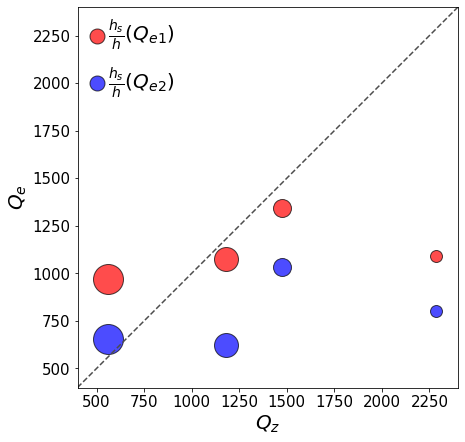

In [36]:
fig0, ax = plt.subplots(figsize=(10,7))


plt.axis('square')   
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$Q_z$', size=20)
plt.ylabel(r'$Q_e$', size=20)

for j in range(len(hs)):
    ax.plot(Qz[j], Qe1[j], marker='o', alpha=.7, ms=6*(j+2), color='red', markeredgecolor='k')
    ax.plot(Qz[j], Qe2[j], marker='o', alpha=.7, ms=6*(j+2), color='blue', markeredgecolor='k')

ax.set(xlim=(400, 2400), ylim=(400, 2400))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
loc_mark1 = [500, 2250]
loc_mark2 = [500, 2000]
plt.plot(loc_mark1[0],loc_mark1[1], marker='o', alpha=.7, ms=15, color='red', markeredgecolor='k')
plt.text(loc_mark1[0]+60, loc_mark1[1]-30, r'$\frac{h_s}{h} (Q_{e1})$', fontsize=20)
plt.plot(loc_mark2[0],loc_mark2[1], marker='o', alpha=.7, ms=15, color='blue', markeredgecolor='k')
plt.text(loc_mark2[0]+60, loc_mark2[1]-30, r'$\frac{h_s}{h} (Q_{e2})$', fontsize=20)

In [ ]:



us = np.empty(len(hs))
Qr = np.empty(len(hs))
Qe = np.empty(len(hs))
h2 = np.empty(len(hs))
u2 = np.empty(len(hs))
for j in range(len(hs)):

    state03 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_rot/state_' + str(format(hs[j],'03d')) + '.nc')
    grid03 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_rot/grid_' + str(format(hs[j],'03d')) + '.nc')
    
    
    gr, qr, qx = FluxCoef(state03,grid03)
    Gr = gr.mean()
    Qr[j] = qr
    #h2[j] = (Cd*((q1/B)**2)/(slp[j]*Gr))**(1/3)
    #u2[j] = (slp[j]*Gr*h2[j]/Cd)**(1/2)
    u2[j] = qx
    #Qe[j] = 0.071 * u1 * B * (h-hs[j])
    
#Qe = 0.06 * (u2/cos_theta) * (h-hs) * B
Qe = 0.071 * slp * u2 * B / (cos_theta**2)

Qe

In [ ]:
def BulkFroude(Hs):
    file = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(Hs,'03d')) + '.nc')
    grid = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/grid_' + str(format(Hs,'03d')) + '.nc')
    state = file.isel(Y=range(1,10), T=range(40,len(file.T)))
    depth = state.Z.data
    xdis = state.X.data
    #gh = np.repeat(np.array([[.5],[1],[1.5],[4],[8]]),10) # Grid height 
    drF = grid.drF.data # r cell face separation
    pres = gsw.p_from_z(depth, 0)
    pt = state.Temp.data.mean(axis=(0,2)) # Y-axis average
    s = state.S.data.mean(axis=(0,2))
    P = np.tile(pres,[len(xdis),1]).T
    rho = gsw.rho(s, pt, P)
    
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u_x = (u0[:, :, :, 1:] + u0[:, :, :, :-1]) / 2 # Convert the value to grid center in x direction
    u = u_x.mean(axis=(0,2)) # dims = Z, X
    #u[u==0] = np.nan
       
    Fr1 = np.empty(len(xdis))
    Fr2 = np.empty(len(xdis))
    U1 = np.empty(len(xdis))
    U2 = np.empty(len(xdis))
    H2 = np.empty(len(xdis))
    Gr = np.empty(len(xdis))
    N = np.empty(len(xdis))
    Mix = np.empty(len(xdis))
    Fr1[[0,-1]] = np.nan
    Fr2[[0,-1]] = np.nan
    U1[[0,-1]] = np.nan
    U2[[0,-1]] = np.nan
    H2[[0,-1]] = np.nan
    Gr[[0,-1]] = np.nan
    N[[0,-1]] = np.nan
    Mix[[0,-1]] = np.nan
    for i in range(1,len(xdis)-1):           
        p = np.where(u[:,i] < 0)[-1][0]
        gh = grid.HFacC.data[:,1:10,i].mean(1) * drF
        h1 = gh[:p].sum()
        u1 = np.sum(u[:p,i] * gh[:p] / h1) 
        rho1 = np.sum(rho[:p,i] * gh[:p] / h1)
        s1 = np.sum(s[:p,i] * gh[:p] / h1)
        
        if sum(j < 0 for j in u[p:,i]) == len(gh)-p:
            n = len(gh) - p
        else:    
            n = np.where(u[p:,i] >= 0)[-1][0]
            
        h2 = gh[p:p+n].sum()
        u2 = np.sum(u[p:p+n,i] * gh[p:p+n] / h2)
        rho2 = np.sum(rho[p:p+n,i] * gh[p:p+n] / h2)
        s2 = np.sum(s[p:p+n,i] * gh[p:p+n] / h2)
        N2array, Parray = gsw.stability.Nsquared(s[:p+n,i], pt[:p+n,i], P[:p+n,i])
        N[i] = N2array.mean()
        Mix[i] = s2 / (s2 - s1)
        g = 9.8 * (rho2-rho1) / rho2
        Fr1[i] = u1 ** 2 / (g * h1)
        Fr2[i] = u2 ** 2 / (g * h2)
        U1[i] = u1
        U2[i] = u2
        H2[i] = h2
        Gr[i] = np.sqrt(g*h2)
        
    h = H2[65]
    U = U2[65]
    Ri = Gr[65] * h / ((U1[65]-U2[65])**2)
    cos = 600 / np.sqrt(600**2 + (150-Hs)**2)
    s = (150-Hs) / np.sqrt(600**2 + (150-Hs)**2)
    Cd = 2.5e-3
    FrB = Fr2[65] / cos
    #ug = np.cbrt(Gr[65]*h*U*s/Cd)
    ug = np.sqrt(Gr[65]*h)
    ns = N[65]
    B = U*h*1800*(ns**1.5)/(Gr[65]**2)
    return (ug, h, Mix)

In [ ]:
file = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(20,'03d')) + '.nc')
state = file.isel(Y=range(1,10), T=range(40,len(file.T)))
depth = state.Z.data
xdis = state.Xp1.data
u = state.U.data.mean(axis=(0,2))
state.X.data[65]

In [ ]:
H = 150
L = 600 # Slope width of the sill
W = 1800 # Fjord width
Hs = np.array([8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22]) # Sill depth [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]

tan = (H-Hs) / L
cos = L / np.sqrt(L**2 + (H-Hs)**2)
sin = (H-Hs) / np.sqrt(L**2 + (H-Hs)**2)
#ns, h, Ri = BulkFroude(13)
Q1, Qr, U2, Ls = QR(10)
U, h, P = BulkFroude(150)
#P[1:-1].mean(), P, Q1

In [ ]:
fig1, ax =plt.subplots(figsize=(10,7))

Re = np.empty(len(Hs))
We = np.empty(len(Hs))
R = np.empty(len(Hs))
for j in range(len(Hs)):
    Q2, Qr, U2, Ls = QR(Hs[j])
    U, h, mix = BulkFroude(Hs[j])
    R[j] = U * np.sqrt(sin[j]/2.5e-3)
    Re[j] = Qr
    #We[j] =  np.sqrt(L**2+(H-Hs[j])**2)
    We[j] = U2 * 0.071 * W * (H-Hs[j])
      
#ax.set(xlim=(3200, 5500), ylim=(3200, 5500))
ax.set(xlim=(0, 3800), ylim=(0, 3800))
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$Q_r (m^3/s)$', size=20)
plt.ylabel(r'$Q_e (m^3/s)$', size=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.plot(Re, We, 'o-', lw=2, label=r'$\frac{Q_r}{Q_oc}$')
#ax.plot(r, Tin_f-Tout_f, 'o-', lw=2, label='dT')
#ax.legend(loc = 'best', fontsize=15)
We

In [ ]:
fig2, ax =plt.subplots(figsize=(10,7))
Qf = 700
r = Hs / H
Pfac = np.empty(len(Hs))
Q1 = np.empty(len(Hs))
QW = np.empty(len(Hs))
R =  np.empty(len(Hs))
for k in range(len(Hs)):
    Q, Qr, Qw, Ls = QR(Hs[k])
    Q1[k] = Q
    QW[k] = Qw
    R[k] = Qr
    
      
ax.set(xlim=(100, 4400), ylim=(100, 4400))
plt.axis('square')   
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xlabel(r'$\frac{H_s}{H}$', size=20)
plt.xlabel(r'$Q_{f1}-Q_{oc1}$', size=20)
plt.ylabel(r'Volume Flux ($m^3/s$)', size=20)
ax.plot(R,Q1, 'o-', lw=2, label='$\overline{P}*Q_{f}-Q_{oc1}$')
ax.plot(R,QW, 'o-', lw=2, label='$Q_{w}$')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.legend(loc = 'best', fontsize=15)
#ax.axhline(y=4900,color='k',linestyle=':')
#ax.axhline(y=Q1.mean(),color='r',linestyle='--')
#ax.plot(r, Tin_f-Tout_f, 'o-', lw=2, label='dT')
#ax.legend(loc = 'best', fontsize=15)
R, Q1

In [37]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Parameter/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig0.savefig(fig_path + '/Entrainment.png', dpi=200, bbox_inches='tight')